**Install necessary packages**

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 36.1 MB/s 


**Mount Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from numpy.core.numeric import count_nonzero
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import visualkeras

**Configurations**

In [ ]:
# provide the path to the image data
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks"
INPUT_DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Winter 2022/Machine Learning(CSC7825)/Final Project_Chest_XRay/chest_xray_balanced')

# image configurations
LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = 128
IMAGE_CHANNEL = 3

# model configuration
MODEL_NAME = 'ChestXRay_ResNet2_Model'
EPOCH = 30
LEARNING_RATE = 0.001
BATCH_SIZE = 16
VERBOSE_MODE = True
INITIAL_WEIGHTS = 'imagenet'
OPTIMIZER = RMSprop(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = 'binary_crossentropy'
METRICS = ['accuracy', 'Precision', 'Recall']

**Augment and scaling the training, validation and test sets**

In [ ]:
training_gen = ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=20,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.2,
                                 )
training_generator = training_gen.flow_from_directory(os.path.join(INPUT_DATA_PATH, 'train'), color_mode='rgb', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary')

validation_gen = ImageDataGenerator(rescale=1.0/255)
validation_generator=validation_gen.flow_from_directory(os.path.join(INPUT_DATA_PATH, 'val'), color_mode='rgb', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary')

test_gen = ImageDataGenerator(rescale=1.0/255)
test_generator=test_gen.flow_from_directory(os.path.join(INPUT_DATA_PATH, 'test'), color_mode='rgb', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary')

Found 1966 images belonging to 2 classes.
Found 610 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
print(training_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


**ResNet Architecture**

In [ ]:
resnet_model = ResNet50(input_shape=[IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNEL], weights= INITIAL_WEIGHTS, include_top=False)

for layers in resnet_model.layers:
    layers.trainable = False

top_layers= resnet_model.output
top_layers = Flatten()(top_layers)
top_layers = tf.keras.layers.Dense(1, activation='sigmoid')(top_layers)

model = Model(inputs=resnet_model.input, outputs=top_layers)

94781440/94765736 [==============================] - 0s 0us/step


**Model summary and visualization**

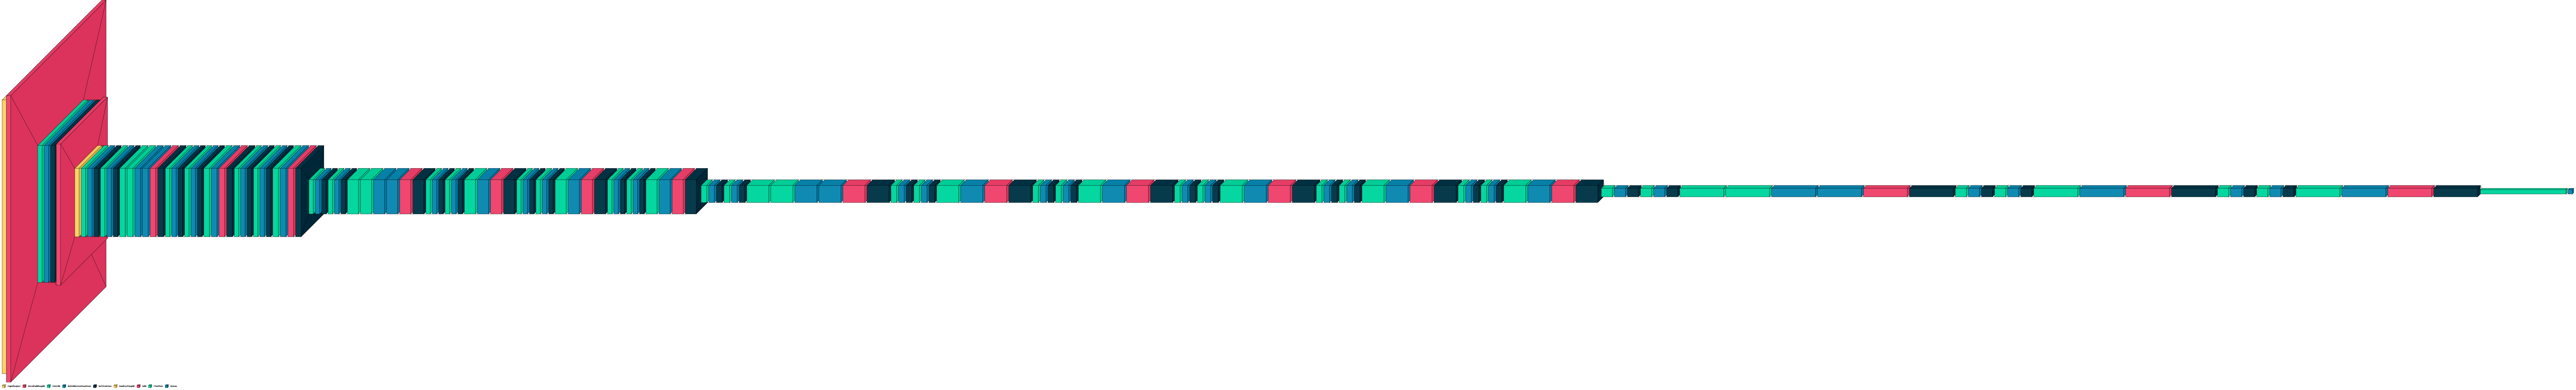

In [ ]:
# model.summary()
visualkeras.layered_view(model, legend=True, scale_z = 0.1, scale_xy=10)

**Configure the model for training**

In [ ]:
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)

**Train the model**

In [ ]:
history = model.fit(training_generator, validation_data = validation_generator, epochs = EPOCH, verbose = VERBOSE_MODE)

Epoch 1/30
123/123 [==============================] - 351s 3s/step - loss: 0.6532 - accuracy: 0.5987 - precision: 0.5934 - recall: 0.6267 - val_loss: 0.5359 - val_accuracy: 0.7475 - val_precision: 0.6875 - val_recall: 0.9226
Epoch 2/30
123/123 [==============================] - 158s 1s/step - loss: 0.5419 - accuracy: 0.7391 - precision: 0.7299 - recall: 0.7589 - val_loss: 0.5821 - val_accuracy: 0.7000 - val_precision: 0.9774 - val_recall: 0.4194
Epoch 3/30
123/123 [==============================] - 157s 1s/step - loss: 0.4913 - accuracy: 0.7640 - precision: 0.7572 - recall: 0.7772 - val_loss: 0.4594 - val_accuracy: 0.8213 - val_precision: 0.9004 - val_recall: 0.7290
Epoch 4/30
123/123 [==============================] - 160s 1s/step - loss: 0.4633 - accuracy: 0.7828 - precision: 0.7763 - recall: 0.7945 - val_loss: 0.4717 - val_accuracy: 0.8016 - val_precision: 0.9276 - val_recall: 0.6613
Epoch 5/30
123/123 [==============================] - 160s 1s/step - loss: 0.4522 - accuracy: 0.7960

**Save the ResNet model**

In [ ]:
model.save(os.path.join(GOOGLE_DRIVE_PATH, MODEL_NAME))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ChestXRay_ResNet2_Model/assets


**Load the ResNet model**

In [ ]:
# model = load_model(os.path.join(GOOGLE_DRIVE_PATH, MODEL_NAME))

**Make prediction on the test data and analyze the result**

In [ ]:
# Report Precision, Recall, F1-Score
result = model.evaluate(test_generator)
print(f"    Loss: {result[0]}")
print(f"    Accuracy: {result[1]}")
print(f"    Precision: {result[2]}")
print(f"    Recall: {result[3]}")


38/38 [==============================] - 35s 903ms/step - loss: 0.2925 - accuracy: 0.8783 - precision: 0.9913 - recall: 0.7633
    Loss: 0.2924543023109436
    Accuracy: 0.878333330154419
    Precision: 0.9913420081138611
    Recall: 0.7633333206176758


**Make Predictions**

In [ ]:
test_generator.reset()
predictions=model.predict_generator(test_generator, verbose=1) #predicted values as probabilities

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


38/38 [==============================] - 37s 940ms/step


In [ ]:
y_pred = np.rint(predictions)
#y_pred

In [ ]:
y_true = test_generator.classes
#y_true

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print(cf_matrix)

[[180 120]
 [189 111]]


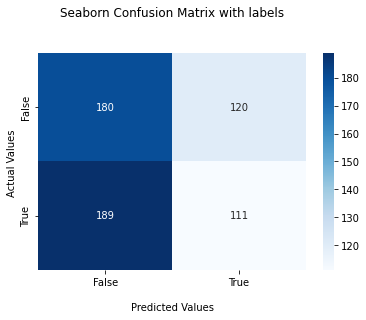

In [ ]:
# Plot the confusion matrix
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()